### Date-Time/torch Practice w/ Time-series Data

In [114]:
import pandas as pd
import numpy as np
import datetime 
import torch
from datetime import date, datetime, timedelta
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, variance, when
import pyspark.sql.functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler
from pyspark.sql.types import *

In [7]:
df = pd.read_csv('./DailyDelhiClimateTrain.csv')
df.head(3)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.5,0.000000,1015.666667
1,2013-01-02,7.400000,92.0,2.980000,1017.800000
2,2013-01-03,7.166667,87.0,4.633333,1018.666667


#### Spark Dataset Dtype configuring/show

In [8]:
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

#Convert date to str
df = spark.createDataFrame(df)
df = df.withColumn("Date", col("Date").cast("string"))

df.printSchema() #DATATYPES

root
 |-- Date: string (nullable = true)
 |-- meantemp: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- meanpressure: double (nullable = true)



In [9]:
df.show(5)

+----------+-----------------+-----------------+------------------+------------------+
|      Date|         meantemp|         humidity|        wind_speed|      meanpressure|
+----------+-----------------+-----------------+------------------+------------------+
|2013-01-01|             10.0|             84.5|               0.0|1015.6666666666666|
|2013-01-02|              7.4|             92.0|              2.98|            1017.8|
|2013-01-03|7.166666666666667|             87.0| 4.633333333333334|1018.6666666666666|
|2013-01-04|8.666666666666666|71.33333333333333|1.2333333333333334|1017.1666666666666|
|2013-01-05|              6.0|86.83333333333333|               3.7|            1016.5|
+----------+-----------------+-----------------+------------------+------------------+
only showing top 5 rows



#### Spark Analysis

In [10]:
for col_ in df.columns[1:]: 
  print(col_+': ',round(df.select(mean(col(col_))).first()[0],3), '(mean) ',
      round(df.select(stddev(col(col_))).first()[0],2), '(stddev) ', round(df.select(variance(col(col_))).first()[0],2), '(variance)', sep='') 

meantemp: 25.496(mean) 7.35(stddev) 53.99(variance)
humidity: 60.772(mean) 16.77(stddev) 281.22(variance)
wind_speed: 6.802(mean) 4.56(stddev) 20.81(variance)
meanpressure: 1011.105(mean) 180.23(stddev) 32483.45(variance)


In [11]:
df.select(F.avg(col('meantemp'))).first()[0]  ### BEST WAY TO DO IT

25.495520655761744

In [12]:
df.select(F.corr('meantemp', 'humidity')).first()[0]

-0.5719507155817208

In [13]:
#Find correlation of columns
for col_ in df.columns:
  for col2 in df.columns:
    if col==col2 or df.select(F.col(col_)).dtypes[0][1] == 'string' or df.select(F.col(col2)).dtypes[0][1] == 'string': pass
    else:print('Correlation ({}, {}):'.format(col_, col2), df.select(F.corr(col_, col2)).first()[0])

Correlation (meantemp, meantemp): 1.0
Correlation (meantemp, humidity): -0.5719507155817208
Correlation (meantemp, wind_speed): 0.30646771079326535
Correlation (meantemp, meanpressure): -0.03881818411702129
Correlation (humidity, meantemp): -0.5719507155817208
Correlation (humidity, humidity): 1.0
Correlation (humidity, wind_speed): -0.3739716746001083
Correlation (humidity, meanpressure): 0.0017337351726500647
Correlation (wind_speed, meantemp): 0.30646771079326535
Correlation (wind_speed, humidity): -0.3739716746001083
Correlation (wind_speed, wind_speed): 1.0
Correlation (wind_speed, meanpressure): -0.020669621285392372
Correlation (meanpressure, meantemp): -0.038818184117021266
Correlation (meanpressure, humidity): 0.0017337351726500426
Correlation (meanpressure, wind_speed): -0.02066962128539236
Correlation (meanpressure, meanpressure): 1.0


In [14]:
df.select(F.col('date')).dtypes[0][1] == 'string'

True

In [15]:
#ORDER BY
df.orderBy(F.col('meantemp').asc()).show(3)

+----------+--------+-----------------+----------+------------+
|      Date|meantemp|         humidity|wind_speed|meanpressure|
+----------+--------+-----------------+----------+------------+
|2013-01-05|     6.0|86.83333333333333|       3.7|      1016.5|
|2013-01-07|     7.0|             78.6|       6.3|      1020.0|
|2013-01-06|     7.0|             82.8|      1.48|      1018.0|
+----------+--------+-----------------+----------+------------+
only showing top 3 rows



In [16]:
df.orderBy(F.col('meantemp').asc(), F.col('wind_speed').asc()).show(5)

+----------+-----------------+-----------------+-----------------+------------------+
|      Date|         meantemp|         humidity|       wind_speed|      meanpressure|
+----------+-----------------+-----------------+-----------------+------------------+
|2013-01-05|              6.0|86.83333333333333|              3.7|            1016.5|
|2013-01-06|              7.0|             82.8|             1.48|            1018.0|
|2013-01-07|              7.0|             78.6|              6.3|            1020.0|
|2013-01-03|7.166666666666667|             87.0|4.633333333333334|1018.6666666666666|
|2013-01-02|              7.4|             92.0|             2.98|            1017.8|
+----------+-----------------+-----------------+-----------------+------------------+
only showing top 5 rows



In [17]:
df.describe().toPandas() #Descriptive Stats

,summary,Date,meantemp,humidity,wind_speed,meanpressure
0,count,1462,1462,1462,1462,1462
1,mean,None,25.495520655761744,60.77170158004638,6.802208747447473,1011.1045475940379
2,stddev,None,7.348102725432477,16.76965226848531,4.561602164272007,180.23166833920956
3,min,2013-01-01,6.0,13.428571428571429,0.0,-3.0416666666666665
4,max,2017-01-01,38.71428571428572,100.0,42.22,7679.333333333333


#### Column Work

In [18]:
df = df.withColumn('wind_speedMPH', col('wind_speed')/1.64) #Create new column
df = df.withColumn('hum_wind_ratio', col('meantemp')/col('wind_speed')).fillna(0)

In [19]:
#multiple columns initiated

df.withColumn('wind_speedM', F.col('wind_speed')/1.64).withColumn('hum_ratio', F.col('meantemp')/F.col('wind_speed')).fillna(0).show(3)

+----------+-----------------+--------+-----------------+------------------+------------------+------------------+------------------+------------------+
|      Date|         meantemp|humidity|       wind_speed|      meanpressure|     wind_speedMPH|    hum_wind_ratio|       wind_speedM|         hum_ratio|
+----------+-----------------+--------+-----------------+------------------+------------------+------------------+------------------+------------------+
|2013-01-01|             10.0|    84.5|              0.0|1015.6666666666666|               0.0|               0.0|               0.0|               0.0|
|2013-01-02|              7.4|    92.0|             2.98|            1017.8|1.8170731707317074|2.4832214765100673|1.8170731707317074|2.4832214765100673|
|2013-01-03|7.166666666666667|    87.0|4.633333333333334|1018.6666666666666|2.8252032520325208|1.5467625899280575|2.8252032520325208|1.5467625899280575|
+----------+-----------------+--------+-----------------+------------------+------

In [20]:
df.show(3)

+----------+-----------------+--------+-----------------+------------------+------------------+------------------+
|      Date|         meantemp|humidity|       wind_speed|      meanpressure|     wind_speedMPH|    hum_wind_ratio|
+----------+-----------------+--------+-----------------+------------------+------------------+------------------+
|2013-01-01|             10.0|    84.5|              0.0|1015.6666666666666|               0.0|               0.0|
|2013-01-02|              7.4|    92.0|             2.98|            1017.8|1.8170731707317074|2.4832214765100673|
|2013-01-03|7.166666666666667|    87.0|4.633333333333334|1018.6666666666666|2.8252032520325208|1.5467625899280575|
+----------+-----------------+--------+-----------------+------------------+------------------+------------------+
only showing top 3 rows



### More Practice from Modules

In [120]:
df = spark.read.csv(
    'spotify_weekly_chart.csv',
        sep = ',',
    header = True,
)
df.printSchema() 

root
 |-- Pos: string (nullable = true)
 |-- P+: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Wks: string (nullable = true)
 |-- Pk: string (nullable = true)
 |-- (x?): string (nullable = true)
 |-- Streams: string (nullable = true)
 |-- Streams+: string (nullable = true)
 |-- Total: string (nullable = true)



In [121]:
df.show(3)

+---+---+------------+-----------+---+---+----+--------+----------+---------+
|Pos| P+|      Artist|      Title|Wks| Pk|(x?)| Streams|  Streams+|    Total|
+---+---+------------+-----------+---+---+----+--------+----------+---------+
|  1|  =|Miley Cyrus |    Flowers|  7|  1|   7|56744018|-5019054.0|585390148|
|  2|NEW|    KAROL G |        TQG|  1|  2|   1|53284451|      null| 53284451|
|  3|NEW| The Weeknd |Die For You|  1|  3|   1|46213370|      null| 46213370|
+---+---+------------+-----------+---+---+----+--------+----------+---------+
only showing top 3 rows



In [122]:
#change data types accordingly. ---> or can use cast() method
new_schema = [
    StructField('Pos', IntegerType(), True),
    StructField('P+', StringType(), True),
    StructField('Artist', StringType(), True),
    StructField('Title', StringType(), True),
    StructField('Wks', IntegerType(), True),
    StructField('Pk', IntegerType(), True),
    StructField('(x?)', IntegerType(), True),
    StructField('Streams', IntegerType(), True),
    StructField('Streams+', DoubleType(), True),
    StructField('Total', IntegerType(), True), 
] 
new_struct = StructType(fields=new_schema)

df = spark.read.csv(
    'spotify_weekly_chart.csv',
    sep=',',
    header=True,
    schema = new_struct
)
df.printSchema()

root
 |-- Pos: integer (nullable = true)
 |-- P+: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Wks: integer (nullable = true)
 |-- Pk: integer (nullable = true)
 |-- (x?): integer (nullable = true)
 |-- Streams: integer (nullable = true)
 |-- Streams+: double (nullable = true)
 |-- Total: integer (nullable = true)



In [123]:
#CLEANSING - fillna() with val from other col
df = df.withColumn("Streams+", F.coalesce(F.col("Streams+"), F.col("Streams")))
df.limit(3).toPandas()
#df.show(3)

,Pos,P+,Artist,Title,Wks,Pk,(x?),Streams,Streams+,Total
0,1,=,Miley Cyrus,Flowers,7,1,7,56744018,-5019054.0,585390148
1,2,NEW,KAROL G,TQG,1,2,1,53284451,53284451.0,53284451
2,3,NEW,The Weeknd,Die For You,1,3,1,46213370,46213370.0,46213370


In [124]:
df.describe().toPandas()

,summary,Pos,P+,Artist,Title,Wks,Pk,(x?),Streams,Streams+,Total
0,count,200,200,200,200,200,200,32,200,200,192
1,mean,100.5,-2.536723163841808,None,505.0,44.32,44.43,4.34375,1.234558693E7,1232550.075,3.857726347291667E8
2,stddev,57.879184513951124,24.042577206838494,None,None,62.79781387226534,45.8743652483026,4.052950936086272,7487267.670902285,5628467.639863396,4.1471066854923165E8
3,min,1,+1,Adele,10:35,1,1,1,7380345,-6062515.0,7470526
4,max,200,RE,Ñengo Flow,lovely,317,195,14,56744018,5.3284451E7,2101461856


In [125]:
#Rename Col
df = df.withColumnRenamed('Pos', 'Rank')


#Drop columns
df = df.drop('P+', 'Pk', '(x?)')
df.show(3)


#Drop NAs
print(df.count())

df = df.na.drop()
print(df.count())

+----+------------+-----------+---+--------+-----------+---------+
|Rank|      Artist|      Title|Wks| Streams|   Streams+|    Total|
+----+------------+-----------+---+--------+-----------+---------+
|   1|Miley Cyrus |    Flowers|  7|56744018| -5019054.0|585390148|
|   2|    KAROL G |        TQG|  1|53284451|5.3284451E7| 53284451|
|   3| The Weeknd |Die For You|  1|46213370| 4.621337E7| 46213370|
+----+------------+-----------+---+--------+-----------+---------+
only showing top 3 rows

200
192


In [126]:
#Data Filtering/PREPROCESSING
df.filter(
    F.col('Total') >= 600000000
).orderBy(F.asc('Streams+')).show(3)

+----+-------------+--------------------+---+--------+----------+----------+
|Rank|       Artist|               Title|Wks| Streams|  Streams+|     Total|
+----+-------------+--------------------+---+--------+----------+----------+
|  10|   Sam Smith |              Unholy| 23|26377166|-1140781.0| 889575567|
|  28|    Bizarrap |Quevedo: Bzrp Mus...| 34|16991984| -927143.0|1055372441|
|  18|Taylor Swift |                Anti| 19|20034882| -890694.0| 619942698|
+----+-------------+--------------------+---+--------+----------+----------+
only showing top 3 rows



In [127]:
#dont need to have lit
df.filter(
    (F.col('Total') >= F.lit(600000000)) & (F.col('Total') <= F.lit(700000000))
).show(3)

#better method:


+----+-------------+-------------------+---+--------+---------+---------+
|Rank|       Artist|              Title|Wks| Streams| Streams+|    Total|
+----+-------------+-------------------+---+--------+---------+---------+
|  14|  The Weeknd |        Die For You| 59|22988828|1333396.0|687729855|
|  18|Taylor Swift |               Anti| 19|20034882|-890694.0|619942698|
|  46| Chris Brown |Under The Influence| 32|14024690| 698968.0|604561746|
+----+-------------+-------------------+---+--------+---------+---------+
only showing top 3 rows



In [128]:
df.filter(
    (df.Total >= F.lit(600000000)) & (df.Total <= F.lit(700000000))
).show(3)

+----+-------------+-------------------+---+--------+---------+---------+
|Rank|       Artist|              Title|Wks| Streams| Streams+|    Total|
+----+-------------+-------------------+---+--------+---------+---------+
|  14|  The Weeknd |        Die For You| 59|22988828|1333396.0|687729855|
|  18|Taylor Swift |               Anti| 19|20034882|-890694.0|619942698|
|  46| Chris Brown |Under The Influence| 32|14024690| 698968.0|604561746|
+----+-------------+-------------------+---+--------+---------+---------+
only showing top 3 rows



In [129]:
df.select('Artist', 'Title',
          F.when(df.Wks >= 35,1).otherwise(0)
          ).show(3)

+------------+-----------+---------------------------------------+
|      Artist|      Title|CASE WHEN (Wks >= 35) THEN 1 ELSE 0 END|
+------------+-----------+---------------------------------------+
|Miley Cyrus |    Flowers|                                      0|
|    KAROL G |        TQG|                                      0|
| The Weeknd |Die For You|                                      0|
+------------+-----------+---------------------------------------+
only showing top 3 rows



In [130]:
#Grouping + Aggregating
df.select(['Artist', 'Wks', 'Total']).groupby('Artist').mean().orderBy('avg(Total)', ascending=False).limit(5).toPandas()

,Artist,avg(Wks),avg(Total)
0,Billie Eilish,254.0,2.098789e+09
1,James Arthur,290.0,1.983256e+09
2,Harry Styles,87.0,1.545701e+09
3,The Neighbourhood,156.0,1.440976e+09
4,Elton John,81.0,1.388794e+09


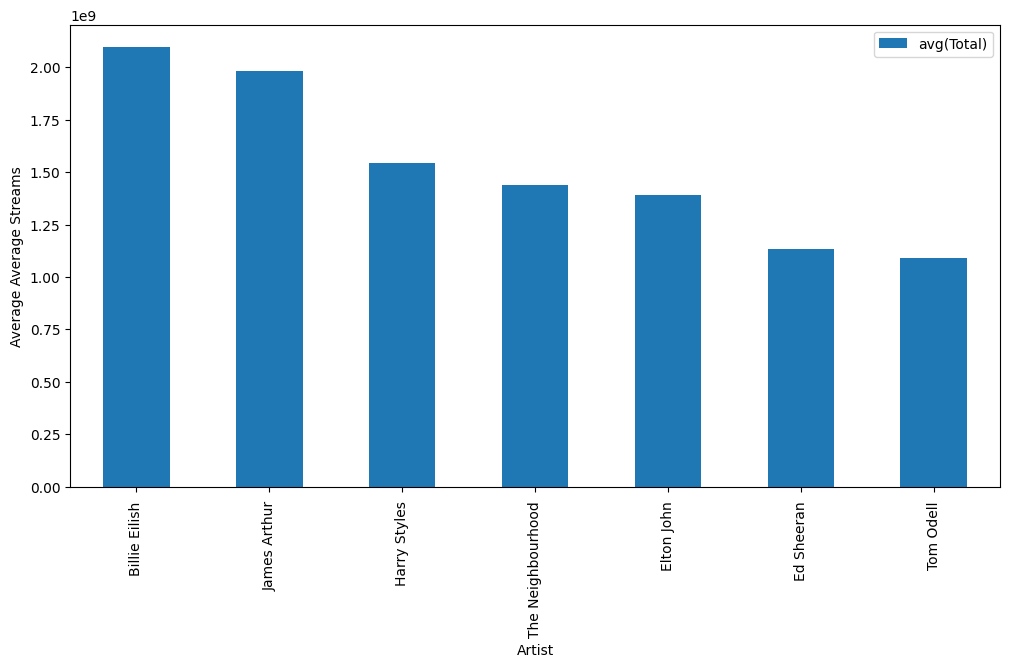

In [131]:
vis_df = (
    df.select(['Artist', 'Wks', 'Total']).groupby('Artist')\
    .mean().orderBy('avg(Total)', ascending=False).toPandas()
)
vis_df.iloc[0:7].plot(
    kind="bar",
    x="Artist",
    y="avg(Total)",
    figsize=(12, 6),
    ylabel="Average Average Streams",
);

In [132]:
## FINAL DATA --> WRITE TO CSV, PERFORM GROUPING + ML 

final_data = (df.select(['Artist', 'Wks', 'Total']).groupBy('Artist').mean().orderBy('Avg(Total)', ascending=False)
)
#final_data.write.save("dataset.parquet", format="parquet")

In [133]:
#StringIndexer - categorical artists
indexer = StringIndexer(inputCol='Artist', outputCol='Artist_encoded').fit(final_data)
final_data = indexer.transform(final_data)

In [134]:
final_data = final_data.withColumn('Artist_encoded', F.col('Artist_encoded').cast('integer')) #convert to integer

In [137]:
final_data.show(3)

+--------------+--------+--------------------+--------------+
|        Artist|avg(Wks)|          avg(Total)|Artist_encoded|
+--------------+--------+--------------------+--------------+
|Billie Eilish |   254.0|       2.098789064E9|             8|
| James Arthur |   290.0|       1.983256195E9|            42|
| Harry Styles |    87.0|1.5457005193333333E9|            34|
+--------------+--------+--------------------+--------------+
only showing top 3 rows



In [ ]:
## Assembling Features
assemble = VectorAssembler(
    inputCols=["Encode_Artist", "avg(Wks)", "avg(Total)"],
    outputCol="features",
)

assembled_data = assemble.transform(encoded_df)

## Standard Scaling
scale = StandardScaler(inputCol="features", outputCol="standardized")
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.show(5)

### Linear Regression Pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler


# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the CSV file
df = spark.read.csv('./Fish.csv', header=True, inferSchema=True)
df.show(3)

+-------+------+-------+-------+-------+-------+------+
|Species|Weight|Length1|Length2|Length3| Height| Width|
+-------+------+-------+-------+-------+-------+------+
|  Bream| 242.0|   23.2|   25.4|   30.0|  11.52|  4.02|
|  Bream| 290.0|   24.0|   26.3|   31.2|  12.48|4.3056|
|  Bream| 340.0|   23.9|   26.5|   31.1|12.3778|4.6961|
+-------+------+-------+-------+-------+-------+------+
only showing top 3 rows



In [ ]:
[print('column:', k, 'dtype:', v) for k,v in df.select([col for col in df.columns]).dtypes][0] #Dtypes

column: Species dtype: string
column: Weight dtype: double
column: Length1 dtype: double
column: Length2 dtype: double
column: Length3 dtype: double
column: Height dtype: double
column: Width dtype: double


In [ ]:
#Find correlation with outcome var
def corr_(var):
  for col_ in df.columns:
    if col_ != var: continue
    for col2 in df.columns:
      if col_==col2 or df.select(F.col(col_)).dtypes[0][1] == 'string' or df.select(F.col(col2)).dtypes[0][1] == 'string': continue
      else:print('Correlation ({}, {}):'.format(col_, col2), df.select(F.corr(col_, col2)).first()[0])

corr_('Weight')

Correlation (Weight, Length1): 0.9157117160312038
Correlation (Weight, Length2): 0.9186177013642219
Correlation (Weight, Length3): 0.9230435593620122
Correlation (Weight, Height): 0.7243453291993317
Correlation (Weight, Width): 0.8865066052433449


In [ ]:
v_assembler = VectorAssembler(inputCols= ['Length3', 'Width'], outputCol='body_features') #Apply vectorization as ML models require this

df_lr = v_assembler.transform(df)
df_lr = df_lr.select(['body_features', 'Weight'])
df_lr.show(3)

+-------------+------+
|body_features|Weight|
+-------------+------+
|  [30.0,4.02]| 242.0|
|[31.2,4.3056]| 290.0|
|[31.1,4.6961]| 340.0|
+-------------+------+
only showing top 3 rows



In [ ]:
splits = df_lr.randomSplit([.8, .2], seed=0)
train_df = splits[0]
test_df = splits[1]

In [ ]:
train_df.show(2)

+-------------+------+
|body_features|Weight|
+-------------+------+
|  [8.8,1.408]|   5.9|
|[10.8,1.0476]|   6.7|
+-------------+------+
only showing top 2 rows



In [ ]:
# find num of rows and columns
print('Training set:', (train_df.count(), len(train_df.columns)))
print('Testing set:', (test_df.count(), len(test_df.columns)))

Training set: (126, 2)
Testing set: (33, 2)


In [ ]:
### Convert spark df of SPLIT to csv file

In [ ]:
#Coef + Intercept of Model + Stats
lr_model = LinearRegression(featuresCol='body_features', labelCol='Weight', maxIter=100).fit(train_df) #can break into 2 lines

#coef+intercept
for i,col_ in enumerate(['Length', 'Width']):
  print('{} Coefficient :'.format(col_), lr_model.coefficients[i])

print('\nIntercept:', lr_model.intercept)

#LR regression summary
summary = lr_model.summary
print('Anova\n______', '\nr2:', round(summary.r2,4), '\t\tr2 adj:', round(summary.r2adj,4), '\nResiduals:', round(summary.residuals.first()[0],4), 
      '\tdof:', summary.degreesOfFreedom, '\n\nT-Stat:', '\nIntercept:', summary.tValues[2], 
       [(k,v) for k,v in zip(['Length', 'Weight'], summary.tValues[0:2])], '\n\nP-Values\n_____', '\nIntercept:', summary.pValues[2], 
       [(i,p) for i,p in zip(['Length', 'Weight'], summary.pValues[0:2])])

Length Coefficient : 21.696749411979653
Width Coefficient : 57.62221768312379

Intercept: -517.8389882465561
Anova
______ 
r2: 0.8852 		r2 adj: 0.8833 
Residuals: 251.6755 	dof: 123 

T-Stat: 
Intercept: -16.086177314569788 [('Length', 10.193715278729284), ('Weight', 4.031212528178358)] 

P-Values
_____ 
Intercept: 0.0 [('Length', 0.0), ('Weight', 9.660307533709833e-05)]


In [ ]:
# Predict and Evaluate Model
y_pred_test = lr_model.transform(test_df)
y_pred_test.show(3)

y_pred = lr_model.transform(train_df)
#training
print('\nTrain Score\n______\nME:', y_pred.select(F.mean(F.abs(y_pred['Weight'] - y_pred['prediction']))).first()[0])

print('MAPE: %{}'.format(y_pred.select(F.mean((y_pred['Weight'] - y_pred['prediction'])/y_pred['Weight'])).first()[0]*100))

#testing
print('\nTest Score\n______\nME:', y_pred_test.select(F.mean(F.abs(y_pred_test['Weight'] - y_pred_test['prediction']))).first()[0])

print('MAPE: %{}'.format(y_pred_test.select(F.mean((y_pred_test['Weight'] - y_pred_test['prediction'])/y_pred_test['Weight'])).first()[0]*100))

+-------------+------+------------------+
|body_features|Weight|        prediction|
+-------------+------+------------------+
|[17.4,2.3142]|  60.0|-6.966212315825146|
|[18.5,2.9415]|  70.0|  53.0466291899761|
| [21.0,2.772]|  85.0| 97.52153682263577|
+-------------+------+------------------+
only showing top 3 rows


Train Score
______
ME: 104.56563941561696
MAPE: %219.9724960394498

Test Score
______
ME: 89.20771784040463
MAPE: %-24.226284867285937


### LR Toyota

In [ ]:
df = spark.read.csv('./ToyotaCorolla.csv', header=True, inferSchema=True)
df.show(5)

+---+--------------------+-----+---------+---------+--------+-----+---------+---+---------+------+---------+----+-----+---------+-----+-------------+------+-------------+---------------+----------------+---+--------+--------+-----+---------------+-------------+---------+------------+---------------+--------------+-----+---------+-----------+----------------+------------+--------------+-----------------+-------+
| Id|               Model|Price|Age_08_04|Mfg_Month|Mfg_Year|   KM|Fuel_Type| HP|Met_Color| Color|Automatic|  CC|Doors|Cylinders|Gears|Quarterly_Tax|Weight|Mfr_Guarantee|BOVAG_Guarantee|Guarantee_Period|ABS|Airbag_1|Airbag_2|Airco|Automatic_airco|Boardcomputer|CD_Player|Central_Lock|Powered_Windows|Power_Steering|Radio|Mistlamps|Sport_Model|Backseat_Divider|Metallic_Rim|Radio_cassette|Parking_Assistant|Tow_Bar|
+---+--------------------+-----+---------+---------+--------+-----+---------+---+---------+------+---------+----+-----+---------+-----+-------------+------+-------------+

In [ ]:
df_lr.printSchema()

root
 |-- Age_08_04: integer (nullable = true)
 |-- KM: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- HP: integer (nullable = true)
 |-- Automatic: integer (nullable = true)
 |-- Doors: integer (nullable = true)
 |-- Quarterly_Tax: integer (nullable = true)
 |-- Mfr_Guarantee: integer (nullable = true)
 |-- Guarantee_Period: integer (nullable = true)
 |-- Airco: integer (nullable = true)
 |-- Automatic_airco: integer (nullable = true)
 |-- CD_Player: integer (nullable = true)
 |-- Powered_Windows: integer (nullable = true)
 |-- Sport_Model: integer (nullable = true)
 |-- Tow_Bar: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [ ]:
df_lr.count()

1436

In [ ]:
df_lr = df.select('Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period',
          'Airco', 'Automatic_airco', 'CD_Player', 'Powered_Windows', 'Sport_Model', 'Tow_Bar', 'Price')

# Create a StringIndexer instance
indexer = StringIndexer(inputCol='Fuel_Type', outputCol='Fuel_Type_Index')

# Fit the indexer to the data
indexer_model = indexer.fit(df_lr)

# Transform the data to obtain the indexed column
df_lr = indexer_model.transform(df_lr)


df_lr.show(5)

#Dummy Vars for FuelType
encoder = OneHotEncoder(inputCol='Fuel_Type_Index', outputCol='Fuel_Type_dummy')  
encoder_model = encoder.fit(df_lr)
df_lr = encoder_model.transform(df_lr)

#Add Index
# df_lr = df_lr.withColumn('index', F.monotonically_increasing_id())
# df =  df.withColumn('index', F.monotonically_increasing_id())

#Add outcome var - Concat Price to feature df

#drop col
df_lr = df_lr.drop('Fuel_Type')

#df_lr.columns
v_assembler = VectorAssembler(inputCols= [x for x in df_lr.columns[0:-1] if x!= 'Price'], outputCol='car_features') #Apply vectorization as ML models require this
df_lr = v_assembler.transform(df_lr)
df_lr.show(3)
df_lr = df_lr.select('car_features', 'Price')
df_lr.show(3)

+---------+-----+---------+---+---------+-----+-------------+-------------+----------------+-----+---------------+---------+---------------+-----------+-------+-----+---------------+
|Age_08_04|   KM|Fuel_Type| HP|Automatic|Doors|Quarterly_Tax|Mfr_Guarantee|Guarantee_Period|Airco|Automatic_airco|CD_Player|Powered_Windows|Sport_Model|Tow_Bar|Price|Fuel_Type_Index|
+---------+-----+---------+---+---------+-----+-------------+-------------+----------------+-----+---------------+---------+---------------+-----------+-------+-----+---------------+
|       23|46986|   Diesel| 90|        0|    3|          210|            0|               3|    0|              0|        0|              1|          0|      0|13500|            1.0|
|       23|72937|   Diesel| 90|        0|    3|          210|            0|               3|    1|              0|        1|              0|          0|      0|13750|            1.0|
|       24|41711|   Diesel| 90|        0|    3|          210|            1|          

In [ ]:
len(df.select('Fuel_Type').distinct().collect()) #The hot encoder not incorporated in vector assembler XXXXXXX

3

In [ ]:
splits = df_lr.randomSplit([.8, .2], seed=0) #SPLIT
train_df = splits[0]
test_df = splits[1]

In [ ]:
#REGRESS SUMMARRY
lr_model = LinearRegression(featuresCol='car_features', labelCol='Price', maxIter=100).fit(train_df)

for i,col_ in enumerate(v_assembler.getInputCols()):
  print('{} Coefficient :'.format(col_), lr_model.coefficients[i])

Age_08_04 Coefficient : -110.48255512214395
KM Coefficient : -0.018066435437563536
HP Coefficient : 29.00275122069008
Automatic Coefficient : 461.4828242824842
Doors Coefficient : 163.1028992516124
Quarterly_Tax Coefficient : 17.870974838964372
Mfr_Guarantee Coefficient : 228.97062826780592
Guarantee_Period Coefficient : 86.06958154948099
Airco Coefficient : 112.10883852364395
Automatic_airco Coefficient : 3359.6852699651054
CD_Player Coefficient : 197.9441441525692
Powered_Windows Coefficient : 407.82178307666413
Sport_Model Coefficient : 371.48910226946504
Tow_Bar Coefficient : -308.4093677391461
Fuel_Type_Index Coefficient : -445.41109008528815


In [ ]:
#EVALUATE MODEL PERFORMANCE
y_pred_test = lr_model.transform(test_df)

y_pred = lr_model.transform(train_df)
y_pred.show(3)

print('\nTrain Score\n______\nME:', y_pred.select(F.mean(F.abs(y_pred['Price'] - y_pred['prediction']))).first()[0])

print('MAPE: %{}'.format(y_pred.select(F.mean((F.abs(y_pred['Price'] - y_pred['prediction']) / y_pred['Price']) * 100)).first()[0]))

#testing
print('\nTest Score\n______\nME:', y_pred_test.select(F.mean(F.abs(y_pred_test['Price'] - y_pred_test['prediction']))).first()[0])

print('MAPE: %{}'.format(y_pred_test.select(F.mean((F.abs(y_pred_test['Price'] - y_pred_test['prediction']) / y_pred_test['Price']) * 100)).first()[0]))

#LR regression summary
summary = lr_model.summary
print('\nAnova\n______', '\nr2:', round(summary.r2,4), '\t\tr2 adj:', round(summary.r2adj,4), '\nResiduals:', round(summary.residuals.first()[0],4), 
      '\tdof:', summary.degreesOfFreedom, '\n\nT-Stat:', '\nIntercept:', summary.tValues[2], 
       [(k,v) for k,v in zip(v_assembler.getInputCols(), summary.tValues[0:-1])], '\n\nP-Values\n_____', '\nIntercept:', summary.pValues[2], 
       [(i,p) for i,p in zip(v_assembler.getInputCols(), summary.pValues[0:-1])])

+--------------------+-----+------------------+
|        car_features|Price|        prediction|
+--------------------+-----+------------------+
|(15,[0,1,2,3,4,5,...|12950|12580.761858091704|
|(15,[0,1,2,3,4,5,...| 8950|  8258.57041931608|
|(15,[0,1,2,3,4,5,...| 8950| 8852.678846258914|
+--------------------+-----+------------------+
only showing top 3 rows


Train Score
______
ME: 927.5648963374546
MAPE: %9.133753295572136

Test Score
______
ME: 855.8839779380901
MAPE: %8.386266147585305

Anova
______ 
r2: 0.8852 		r2 adj: 0.8837 
Residuals: 369.2381 	dof: 1110 

T-Stat: 
Intercept: 9.515371874829308 [('Age_08_04', -34.59150912282249), ('KM', -13.022185693611569), ('HP', 9.515371874829308), ('Automatic', 2.7586379030746113), ('Doors', 3.9683161398542444), ('Quarterly_Tax', 11.046282106015676), ('Mfr_Guarantee', 2.867825442461807), ('Guarantee_Period', 6.776161979479968), ('Airco', 1.1556636408268874), ('Automatic_airco', 17.497749514983294), ('CD_Player', 1.8515417195324873), ('Powere

### DateTime

In [ ]:
duration = timedelta(days=2, hours=4, minutes=30)
df['date'] = datetime.strptime(df['date'], "%Y-%m-%d")

print("Duration:", duration)

TypeError: ignored

In [ ]:
# Parse a string into a datetime object
date_string = "2022-05-10"
parsed_date = datetime.strptime(date_string, "%Y-%m-%d")
print("Parsed Date:", parsed_date)

In [ ]:
for i in range(3):
  print('iteration {}'.format(i+1))

iteration 1
iteration 2
iteration 3
